In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
# import cv2
import os
from xml.dom import minidom
import copy

In [2]:
doc = minidom.parse("data/lineStrokes/a01/a01-001/a01-001z-01.xml")

In [3]:
strokes = doc.getElementsByTagName('Stroke')

In [4]:
points = strokes[0].getElementsByTagName('Point')

In [5]:
points[0].getAttribute("x")

'895'

In [8]:
def n_grams(data, n):
    data_points = []
    for i in range(0,data.shape[0]-n-1):
        data_points.append((data[i:i+n],data[i+n]))
    return data_points

def get(po,att):
    return int(po.getAttribute(att))

def read_strokes(doc):
    strokes = doc.getElementsByTagName('Stroke')
    ret = []
    for stroke in strokes:
        points = stroke.getElementsByTagName('Point')
        for i in range(len(points)-1):
            ret.append([get(points[i],'x') , get(points[i],'y'), 0])
        ret.append([get(points[-1],'x') , get(points[-1],'y'), 1])
    return np.array(ret,dtype='float')

def create_data(path):
    f = open(path, 'r')
    arr = f.readlines()
    data = []
    for useri in arr:
        user = useri.replace(' ','')
        user = user.replace('\n','')
        p = 'data/lineStrokes/'+user[:3]+'/'+user[:7]+'/'
        fi = [x for x in os.listdir(p)]
        fi.sort()
        for file in fi:
#             print(file[:-7], user, len(user))
            if file[:-7] == user:
                d = read_strokes(doc)
                da = n_grams(d, 400)
                for po in da:
                    data.append(po)
    return data

In [38]:
train_data = create_data('data/trainset.txt')

In [45]:
train_data[0]

(array([[ 895.,  992.,    0.],
        [ 890.,  987.,    0.],
        [ 894.,  993.,    0.],
        ...,
        [3660., 1596.,    0.],
        [3677., 1608.,    0.],
        [3701., 1615.,    0.]]),
 array([3723., 1616.,    0.]))

In [58]:
def mean_shift_data(data):
#     d = []
    new_data = []
    for i in range(len(data)):
        if i%10000 == 0:
            print('Got this  ',i)
        x1 = data[i][0][0][0]
        x2 = data[i][0][0][1]
        nd = np.zeros((401,3))
        for j in range(400):
            nd[j][0] = data[i][0][j][0] - x1
            nd[j][1] = data[i][0][j][1] - x2
            x1 = data[i][0][j][0]
            x2 = data[i][0][j][1]
        nd[400][0] = data[i][1][0] - x1
        nd[400][1] = data[i][1][1] - x2
        ux = 1.0*(nd[:,0].sum())/401.0
        uy = 1.0*(nd[:,1].sum())/401.0
        sx = ((1.0*(np.sum(nd[:,0]**2))/401.0) - ux**2)**0.5
        sy = ((1.0*(np.sum(nd[:,1]**2))/401.0) - uy**2)**0.5
        if sx == 0:
            sx = 1
        if sy == 0:
            sy = 1
        for j in range(401):
            nd[j][0] = (nd[j][0]-ux)/sx
            nd[j][1] = (nd[j][1]-uy)/sy  
        new_data.append((nd[:400],nd[400]))
    return new_data

In [59]:
data = mean_shift_data(train_data[0:100000])

Got this   0
Got this   10000
Got this   20000
Got this   30000
Got this   40000
Got this   50000
Got this   60000
Got this   70000
Got this   80000
Got this   90000


In [65]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np 

# %matplotlib inline

# for reproducibility
torch.manual_seed(1)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [157]:
def loss_function(output, label):
    pro = torch.zeros([label.shape[0]]).to(device)
    for i in range(20):
        w = output[:,i]
        ux = output[:,20+i]
        uy = output[:,40+i]
        sx = output[:,60+i]
        sy = output[:,80+i]
        r = output[:,100+i]
#         print(w,ux,uy,sx,sy,r)
        Z = (label[:,0]-ux)**2/(sx**2) + (label[:,1]-uy)**2/(sy**2) - 2*r*(label[:,0]-ux)*(label[:,1]-uy)/(sx*sy)
#         print(Z.shape)
        N = torch.exp(-Z/(2*(1-r**2)))/(2*torch.pi*sx*sy*((1-r**2)**0.5))
#         print(r.shape, N.shape,w.shape)
        pro += w*N
#     print(pro)
    pro = label[:,2]*pro*output[:,120]+(1-label[:,2])*pro*output[:,120]
    return -torch.sum(torch.log(pro)), pro

In [147]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm = nn.LSTM(input_size=3, hidden_size=3, num_layers=2, dropout=0.4, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(1200,400)
        self.fc2 = nn.Linear(400, 121)
        self.flat = nn.Flatten()
    def forward(self, x):
        x = x.float()
        batch_size = x.shape[0]
        hidden = (torch.zeros(2, batch_size, 3), torch.zeros(2, batch_size, 3))
        out, hidden = self.lstm(x)
        x = self.flat(out)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x[:,120] = 1/(1+torch.exp(x[:,-1]))
        x[:,:20] = F.softmax(x[:,:20],dim=1)
        x[:,60:100] = torch.exp(x[:,60:100])
        x[:,100:120] = torch.tanh(x[:,100:120])
        return x

In [159]:
def trainvalAdam(model, train_data, valid_data, device, batch_size=512, num_iters=1, learn_rate=0.01, classes = 6):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch
#     val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
#     criterion = nn.CrossEntropyLoss()
#     criterion = loss_function()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.90, 0.98), eps=1e-08, weight_decay=0, amsgrad=False)
    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []
    best = 1e9
    prev = 0
    n = 0 # the number of iterations
    for n in tqdm(range(num_iters)):
        tot_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            model.train() #*****************************#
            optimizer.zero_grad()         # a clean up step for PyTorch
            out = model(imgs)             # forward pass
            loss, pro = loss_function(out, labels) # compute the total loss
            if float(loss)<0:
                print(pro.detach().numpy())
            tot_loss += float(loss)
            loss.backward()               # backward pass (compute parameter updates)
            threshold = 2.0
            for p in model.parameters():
                if p.grad.norm() > threshold:
                    torch.nn.utils.clip_grad_norm_(p, threshold)
            optimizer.step()              # make the updates for each parameter

        # save the current training information
        # if n % 10 != 10:
        iters.append(n)
        losses.append(float(tot_loss))        # compute *average* loss
        print('Epoch no ',n,'   and training loss: ',tot_loss)
#         train_accuracy = get_accuracy(model, train_data, device)
#         val_accuracy = get_accuracy(model, valid_data, device)
#         for im, lb in val_loader:
#             im, lb = im.to(device), lb.to(device)
#             val_out = model(im)
#             val_loss = criterion(val_out, lb)
#         vl = float(val_loss)/batch_size
#         val_losses.append(float(val_loss)/batch_size)
#         train_acc.append(train_accuracy) # compute training accuracy 
#         val_acc.append(val_accuracy)   # compute validation accuracy
#         if vl<best:
#           prev = n
#           best = vl
#         if (n-prev)>20:
#             print('Early stopping ')
#             break
    return iters, val_losses, losses, val_acc, train_acc 


In [121]:
model = RNN()
model.to(device)
iters, val_losses, losses, val_acc, train_acc = trainvalAdam(model, data, data, device, num_iters=60)

100%|██████████| 60/60 [1:05:44<00:00, 65.74s/it]


In [140]:
torch.save(model.state_dict(), 'exploding_gradient_onhp_model')

Text(0, 0.5, 'Training loss')

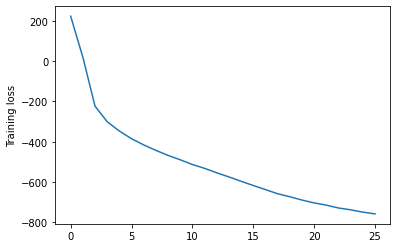

In [136]:
plt.plot(iters, losses)
plt.ylabel('Training loss')

In [137]:
losses[-1]

nan

**Last Values of Loss are nan**<br>
*The reason for this is exploding gradient problem in the LSTM. Now we will solve this by cliiping model parameters.*

In [160]:
model = RNN()
model.to(device)
iters, val_losses, losses, val_acc, train_acc = trainvalAdam(model, data, data, device, num_iters=60)

  2%|▏         | 1/60 [01:05<1:04:24, 65.51s/it]

Epoch no  0    and training loss:  142539.7152828932


  3%|▎         | 2/60 [02:16<1:06:10, 68.45s/it]

Epoch no  1    and training loss:  111239.81678412645


  5%|▌         | 3/60 [03:42<1:12:40, 76.50s/it]

Epoch no  2    and training loss:  102502.51910824933


  7%|▋         | 4/60 [05:09<1:15:20, 80.73s/it]

Epoch no  3    and training loss:  87351.30741836886


  8%|▊         | 5/60 [06:27<1:13:05, 79.75s/it]

Epoch no  4    and training loss:  60188.68214070629


 10%|█         | 6/60 [07:44<1:11:07, 79.03s/it]

Epoch no  5    and training loss:  29574.587472059375
[1.62031926e+00 8.07817316e-01 1.37067618e+00 7.21988934e-01
 2.04427898e+00 1.42929340e+00 1.75476131e+00 3.81795851e+00
 1.03032181e+00 3.20441758e-01 2.52941805e+00 1.13251067e+00
 7.39093082e-01 2.63605990e-01 5.77237605e-01 1.40431022e+00
 1.64146253e+00 2.50625785e-01 2.44922058e+00 1.35620797e+00
 1.63811431e+00 9.36642339e-01 8.26402840e-01 8.81575092e-01
 3.39678912e+00 1.24959433e+00 2.79017038e+00 1.05761792e+00
 1.42280610e+00 1.62016541e+00 1.56751224e+00 7.84630144e-01
 2.34047732e+00 1.64528001e+00 6.80018451e-01 6.00705501e-01
 1.96208325e+00 1.82743065e+00 1.81279772e+00 3.08709239e+00
 2.89485084e+00 4.02027793e+00 2.97658916e+00 1.11295683e+00
 1.84788891e+00 2.07646133e+00 2.68954590e+00 3.18760873e+00
 1.53670697e+00 1.64402434e+00 6.23118605e-01 1.06217502e+00
 1.81340190e-01 9.38763885e-01 4.55276989e+00 2.76465695e+00
 2.11307857e+00 7.20995056e-01 6.46900502e-01 4.70227658e+00
 6.39580121e-01 9.09108122e-01 

[2.01783397e+00 2.26592208e+00 3.45444574e+00 4.17881885e+00
 7.32852244e-01 1.48618156e+00 1.78351810e+00 2.58553445e+00
 2.56608184e+00 6.61833394e-01 7.10804072e-01 3.15155479e-01
 6.61825755e-01 1.33428727e-03 2.19531470e+00 4.10579416e-01
 1.96187598e+00 1.20833994e+00 2.26680507e+00 2.43729761e+00
 3.13587876e-01 6.05956217e-01 1.40950881e+00 1.81458653e+00
 2.19254571e+00 1.31046445e+00 2.54091576e-04 1.62794802e+00
 4.57196989e+00 1.88208057e+00 2.70107118e-01 1.54174872e+00
 1.08948453e+00 2.29081047e+00 2.10034561e+00 1.74695224e+00
 3.17725510e+00 1.52199670e+00 1.43754634e+00 1.12724205e+00
 4.48401223e+00 2.15796547e+00 1.66716078e+00 1.88873315e+00
 1.45902324e+00 1.47876503e+00 1.20257859e-01 3.85012438e-02
 1.87061755e+00 1.06089757e+00 2.15615069e+00 1.00270458e+00
 3.56444586e+00 3.57235083e-01 6.98079095e-01 1.00778018e+00
 4.85123771e+00 8.70144133e-01 2.53118811e+00 2.16952720e+00
 2.08648755e+00 4.15622365e-01 1.63089982e+00 5.27058033e-04
 1.13095359e+00 2.695940

[1.61678359e+00 2.60876589e+00 9.66402691e-01 2.30773565e+00
 4.20229992e-01 1.32590586e+00 1.81995800e+00 3.74742845e-01
 2.43845825e+00 9.55693795e-01 1.90501343e+00 3.77114549e+00
 1.15742446e+00 1.04267712e+00 6.37842382e-05 2.01949137e+00
 1.24317822e+00 2.90363491e+00 7.87012185e-01 2.45702201e+00
 2.41322826e+00 3.68190591e-01 1.42957606e+00 1.67809485e+00
 4.22135162e-01 1.05796094e+00 5.51610815e+00 2.22971723e+00
 4.41038206e+00 2.31865531e+00 2.11854113e+00 8.92173680e-01
 1.52917605e+00 9.15144743e-01 1.22228015e-01 1.81839603e+00
 1.38389221e+00 2.89336316e+00 2.22193114e+00 1.62736918e+00
 2.37836928e+00 2.70605946e-01 1.16372140e+00 1.63974094e+00
 7.31712974e-01 1.23565894e+00 3.46999855e-04 1.32825041e-01
 3.48771712e-01 2.82170346e+00 2.05310479e-01 3.47833167e+00
 1.76458030e+00 1.41206541e+00 9.37079077e-01 2.72871236e+00
 2.59308407e+00 9.51014532e-01 9.52844619e-01 1.67955638e+00
 1.76490324e+00 2.81863805e+00 1.03361655e+00 1.44659238e+00
 5.26362651e-01 1.698550

[2.77474386e+00 1.86962759e+00 1.59643206e+00 1.95470534e+00
 1.47982113e+00 3.09619741e+00 1.68323692e+00 1.36577245e+00
 2.10827066e+00 1.64942412e+00 1.64010612e-04 7.63185510e-01
 4.00009816e+00 1.65416001e+00 6.03200451e-01 5.49373556e-01
 2.32647062e+00 2.22190464e+00 1.18218659e+00 4.19944838e-01
 1.38491233e+00 1.06210638e+00 2.52667700e-01 2.17084059e+00
 2.81772455e+00 1.56006992e+00 2.06676573e+00 1.51192672e+00
 9.68088825e-01 1.02482225e-01 1.67850676e+00 7.40942728e-01
 2.39043114e-01 2.45392631e+00 3.93911401e-01 4.80130281e-01
 8.72291192e-01 1.36932716e+00 1.18067291e+00 1.90856465e+00
 2.45983138e+00 1.63334751e+00 2.27719146e+00 3.02799134e+00
 1.62958372e+00 1.72920300e+00 1.52239063e+00 8.76354859e-01
 4.15750208e-01 1.42515802e+00 2.11573299e-01 2.90954667e+00
 7.61609764e-01 2.82719023e+00 5.02657808e-01 3.14990189e-01
 1.33507883e+00 1.42551496e+00 1.40192663e+00 1.04021958e+00
 3.77464412e+00 1.01408423e+00 1.65823931e+00 7.43362135e-01
 1.34690003e+00 1.068133

[4.36856705e+00 7.14073411e-01 9.20343403e-02 1.45127332e+00
 1.64237493e+00 9.38409671e-01 8.90366953e-01 2.08446302e+00
 4.82567664e-01 1.03242799e-02 5.12918025e-01 4.75992056e+00
 1.52575363e-01 3.03297411e-01 1.97096775e+00 1.35685917e+00
 4.32579592e-01 2.25578946e+00 1.24154882e+00 7.93458445e-01
 1.38860612e+00 1.59217322e+00 2.58172106e+00 2.32120683e+00
 2.12816745e+00 2.37619452e-01 2.18085778e+00 1.45850720e+00
 1.03042485e+00 7.43958573e-01 8.23770300e-01 1.96859624e+00
 1.29681212e-01 9.11875920e-01 5.38623888e-01 4.10487874e+00
 1.50367178e+00 1.48021297e+00 1.56401622e+00 5.89419077e+00
 3.26640191e-01 2.69818590e+00 7.81729078e-01 1.21726770e+00
 1.98831628e+00 9.23957810e-01 1.58798351e+00 1.87776579e+00
 3.59090218e+00 1.34507517e+00 1.17141299e+00 1.72916592e+00
 1.94220368e+00 1.21548853e+00 3.87244720e+00 3.09219176e+00
 1.07831166e+00 1.62676128e-01 1.26929645e+00 3.94701303e+00
 1.15991186e+00 3.15744119e+00 1.83024012e+00 1.06429865e+00
 4.24372631e-01 1.474173

[2.15220257e+00 2.68261805e-01 1.01151295e+00 5.47289483e+00
 2.45221108e+00 2.52181322e+00 2.96437967e+00 3.76628792e-01
 1.50161445e+00 4.20030658e+00 1.07059093e+00 1.78869533e+00
 1.66740491e+00 6.53574936e-01 6.90965088e-01 9.22420023e-01
 2.16503941e+00 3.57377161e+00 1.11685433e-01 3.59710504e+00
 2.76496064e+00 1.06461263e+00 1.75799869e+00 6.01336157e-02
 2.98741741e+00 3.14044957e+00 1.13575512e+00 2.47014136e+00
 9.40322188e-01 1.24535163e+00 2.26916077e+00 3.06084869e+00
 6.82856116e-01 4.18208399e+00 2.02805623e+00 4.96205739e+00
 7.34037109e-01 3.25483548e+00 6.84218867e-01 3.81325654e+00
 1.15059886e+00 9.49066749e-01 1.47470582e+00 2.75410494e-02
 3.80959102e+00 3.78913262e+00 3.10360298e-01 1.22602883e+00
 2.37485402e+00 7.43611118e-01 1.76404523e+00 3.58112159e+00
 1.21097341e+00 2.35682243e+00 1.47847482e+00 3.66101299e-02
 2.55347382e+00 2.87805955e+00 1.44451649e+00 9.13617087e-01
 4.59917705e+00 9.39765692e-01 1.57036551e+00 9.55826949e-01
 3.57792827e+00 2.382837

[2.04827095e+00 2.52801108e+00 5.42054399e+00 2.92364376e-01
 7.26577487e-01 2.12240245e+00 2.33099121e+00 1.50715594e+00
 1.40014366e+00 2.71345410e+00 1.59973060e+00 5.87149907e-01
 2.07153284e+00 1.04913857e+00 9.36385954e-01 2.05034260e+00
 3.31969773e+00 1.86784216e+00 9.67183660e-01 1.66777274e+00
 7.00871433e-01 2.68105924e+00 2.36030595e+00 1.50073848e+00
 2.86176610e+00 5.36702551e-01 2.48312470e+00 8.41236689e-01
 1.35340567e+00 3.90593221e-01 2.09323902e+00 3.43300084e-01
 1.87131024e+00 1.32409437e+00 2.04528879e+00 1.92771619e+00
 1.02829748e+00 1.82638967e+00 1.92445683e+00 1.38682073e+00
 1.90743788e+00 1.67290103e-02 5.31345905e+00 1.08297722e+00
 2.42023011e+00 1.39705298e-01 2.03771383e+00 7.77028702e-01
 2.96122254e-01 1.20045178e+00 1.62016635e+00 1.47127401e+00
 2.44183368e+00 2.39114811e+00 1.41098564e+00 2.02630568e+00
 1.01641815e-01 7.02004651e-01 1.02674660e+00 9.15871818e-01
 4.28729086e-01 1.21548211e-03 4.27375838e-01 3.95314713e-04
 4.05675066e-04 1.825046

[3.48739328e-01 4.68767128e-04 1.19808402e+00 6.84452746e-01
 2.66792231e+00 1.04457472e+00 1.73451930e+00 1.00613167e+00
 8.49339773e-02 7.48101235e-01 1.79413789e+00 1.48823608e+00
 8.27370166e-01 4.60880651e-01 1.03712666e+00 9.34247181e-02
 1.63248570e+00 2.24185155e+00 1.23782136e+00 1.58792245e+00
 2.78275570e+00 1.33344046e+00 1.18120109e+00 8.49039341e-01
 9.16795295e+00 1.68638728e+00 5.96107221e-01 1.91612867e+00
 2.00663371e+00 1.44702573e+00 1.03379981e+00 1.82442188e+00
 3.04173594e+00 2.82536042e+00 1.75280669e+00 1.22639623e+00
 1.79132206e+00 2.64675988e+00 1.11405033e+00 5.72350704e+00
 1.97883828e+00 1.76232422e+00 3.81220924e-01 2.61376693e+00
 3.59183078e+00 9.17774902e-01 1.10153465e+00 4.23593389e-01
 1.61664285e+00 3.93910955e-01 1.30002773e+00 1.46671173e+00
 1.78613836e+00 3.14448525e-01 3.10629803e+00 1.98924946e+00
 1.14003225e+00 6.95696300e-01 3.38448434e+00 1.58815394e+00
 2.18731754e+00 3.10353144e+00 8.88909584e-01 1.65550210e-01
 3.22699759e+00 3.840361

[2.74645352e+00 1.24664259e+00 1.25934049e+00 3.13619967e+00
 1.77442242e-01 2.59506301e+00 2.82458618e+00 2.89079344e+00
 2.61568113e+00 2.25416435e+00 2.60005227e+00 4.10377821e+00
 1.08571045e+00 6.14217596e-01 1.96720325e+00 3.77117794e+00
 7.57844151e-01 3.95941910e+00 1.59021472e+00 3.49407357e-01
 4.01297966e-01 5.40167416e-02 2.90700364e+00 1.02864269e+00
 9.46704974e-01 1.81078558e-01 2.14292445e+00 2.32187740e+00
 2.14801757e-01 1.83224876e-01 1.28940853e+00 3.14549290e+00
 7.50757449e-01 2.11738747e+00 1.21112062e+00 1.02577142e+00
 2.09069905e-01 1.40032304e+00 8.50665953e-01 1.12139789e+00
 2.05558745e+00 4.67109099e+00 2.41032484e+00 3.59080684e+00
 2.44283634e+00 2.40455959e+00 2.33786663e+00 2.50678620e-01
 2.40542865e+00 8.96667371e-01 2.94064924e-02 3.17004052e+00
 4.09531198e-01 1.01749124e+00 4.53196681e+00 1.38728383e+00
 2.94596867e-01 3.96276927e+00 1.23150583e+00 1.02682231e+00
 1.29326919e+00 3.33097944e+00 1.35602555e+00 1.64423078e+00
 4.87117804e-01 2.486772

[6.86317811e-01 2.34026909e-01 1.49138038e+00 1.65375137e+00
 6.61843299e-01 1.62349433e+00 1.37992385e+00 3.22883614e+00
 9.61574848e-01 5.55610936e-01 3.59626344e+00 1.05308327e+00
 5.23410124e-01 1.34199529e+00 5.90033696e-01 1.83320280e-01
 1.08056363e+00 1.53466622e+00 9.88009185e-01 4.74492401e-01
 8.40782847e-01 4.46694633e+00 8.87673534e-01 9.01518921e-01
 8.00225566e-04 1.63448648e+00 3.61147342e+00 1.96431143e+00
 1.72551323e+00 1.51362785e+00 3.99621977e+00 8.65917307e-01
 1.42102911e+00 1.85494295e+00 2.16123386e+00 1.00362012e-04
 1.10543634e+00 2.89575151e+00 5.79586634e-01 1.19819037e+00
 3.12620284e-01 1.07836284e+00 3.98251428e-01 2.02387614e+00
 2.33123318e+00 6.91238181e-01 1.84719849e+00 2.41623840e+00
 2.44166084e+00 4.82190494e-01 8.01022292e-01 1.76318982e+00
 1.91575613e+00 5.73949866e+00 3.88919639e+00 6.57440345e-01
 4.51103606e-01 2.31234000e+00 2.92513796e+00 1.92697406e+00
 1.96038097e+00 9.13873453e-01 5.06678074e-01 1.12395665e+00
 4.49126471e-01 5.825954

[1.68469469e+00 1.62710052e+00 4.56493460e-01 7.16325347e-01
 2.79959628e+00 1.37110696e+00 1.85572126e+00 1.37634692e+00
 2.91878975e+00 1.64904242e+00 1.25283922e+00 2.06409370e+00
 8.98243067e-01 4.58961170e-01 2.06474378e+00 1.25883661e+00
 2.65415173e+00 5.78521356e-01 1.27366131e+00 1.13214106e+00
 2.55196908e+00 3.37161619e-01 1.03686973e+00 1.69783454e-01
 9.06882118e-01 2.91550766e+00 1.70214898e+00 5.55553812e-01
 2.57836169e+00 2.51049017e+00 7.48593833e-01 1.55277693e+00
 2.49778085e+00 3.65590649e-01 2.60072269e+00 4.65423245e+00
 6.24455815e-01 9.07029791e-04 1.01781562e+00 3.52458014e+00
 1.92484546e+00 1.05802521e+00 3.32958553e+00 2.25933314e+00
 2.07201045e+00 2.93632604e+00 1.51039675e+00 2.03849885e+00
 1.73645783e+00 3.01180429e+00 1.62142704e+00 1.01003366e+00
 1.75744919e+00 2.32995775e+00 2.05098805e+00 1.83812081e+00
 2.30612597e-01 5.31359676e-01 2.63407872e+00 1.97397921e+00
 2.73274506e+00 2.95693351e-04 1.68319167e+00 3.98546992e+00
 1.19026902e+00 6.125174

[6.95257036e-01 1.85734161e+00 4.55369472e+00 2.13126770e+00
 1.45081621e+00 2.30085349e+00 1.11599773e+00 1.52675355e+00
 1.13363742e+00 3.02110087e+00 2.70172256e+00 2.34293279e+00
 1.09738365e+00 8.80952753e-01 3.91393555e+00 1.95588853e+00
 9.78083912e-01 1.96674173e-01 4.70071841e+00 9.03197028e-01
 1.61468490e+00 4.06896768e+00 4.48128799e-01 4.91066134e-01
 1.24406298e+00 6.85457500e-01 1.12878731e+00 5.01506273e+00
 3.34272585e+00 1.57249924e+00 4.43326977e-01 3.56273014e+00
 1.03498190e+00 8.15319377e-01 4.10462199e-01 1.72356322e+00
 2.57581762e+00 2.17298905e+00 1.53497123e+00 1.15749709e+00
 2.70429462e+00 1.11688559e+00 1.72625788e+00 1.60217468e+00
 1.70942077e+00 2.51915033e+00 1.95689591e+00 7.22157516e-01
 1.42071571e+00 7.18974114e+00 1.49580910e+00 3.36510258e-02
 1.80771896e+00 1.85591310e+00 1.01331431e+00 6.61286203e-01
 1.94650572e-01 3.00083972e+00 3.28690816e+00 2.91525501e+00
 1.77268620e+00 7.06386481e-01 4.49251866e+00 3.12405320e+00
 6.93517997e-01 1.697205

[1.25040322e+00 3.87484014e+00 2.68218164e+00 1.17174620e+00
 4.31872903e-01 3.84564475e-01 2.40350145e+00 2.39739555e-01
 1.11574738e-04 2.59131049e+00 5.68445473e-01 1.97799682e+00
 3.30182453e+00 1.33308507e+00 2.68333736e+00 5.13159552e-02
 1.87619910e-02 1.21178046e+00 1.78651592e+00 5.39513047e-01
 8.06397671e-02 1.31026804e+00 1.52531370e+00 2.63177693e-01
 3.46699363e+00 3.18740473e-01 2.03062337e+00 4.10500734e-01
 2.44329473e+00 4.04243515e-02 6.79150550e-01 1.49271906e+00
 7.13949023e+00 1.85113551e+00 1.74893406e+00 1.63542064e+00
 4.81066656e-01 7.83289965e-01 1.91354926e+00 2.30251364e+00
 2.87643896e+00 4.50919029e+00 1.04403016e+00 1.27355059e+00
 5.55454454e-01 1.46335276e+00 2.16631120e+00 1.61975738e-01
 1.66306576e+00 5.92929084e-01 2.11060559e-04 1.98400785e+00
 1.49528508e+00 1.62856657e+00 2.35041847e-01 2.76095822e+00
 3.07824381e+00 1.86839340e+00 1.70107141e+00 2.97218456e+00
 6.23537816e-01 1.56195201e+00 1.63237873e+00 1.53152854e+00
 3.15501047e+00 2.541955

[3.27406410e+00 1.42280515e+00 1.82135450e+00 2.27860710e+00
 1.32874809e+00 1.45349227e+00 7.11468350e+00 5.13448375e+00
 1.87952965e+00 3.38795135e+00 1.46696969e+00 1.42513903e-01
 2.60332550e+00 3.11201708e-01 2.14552367e+00 4.61824716e-01
 6.69219348e-01 1.03888076e+00 7.10997615e-01 1.90544875e+00
 3.33012773e-02 7.43977980e-01 3.33735674e+00 8.00483777e-01
 7.95057826e-02 5.39863100e-01 3.38175521e-01 3.54658220e+00
 1.79804047e+00 1.57265631e+00 2.36440811e+00 3.66536669e+00
 3.78325015e-01 4.83999602e-01 7.75755923e+00 1.64056278e+00
 4.02145295e+00 3.15863311e+00 2.55404713e+00 3.24814683e+00
 1.60176330e+00 1.80586971e+00 1.25343649e+00 8.71769331e-01
 1.79379256e+00 1.70205797e+00 2.32424433e+00 1.67273410e+00
 6.66454584e-01 1.19972721e+00 3.49409162e-01 1.00501589e+00
 8.91492899e-01 3.51597831e-01 1.54162914e+00 9.55729374e-01
 2.01918671e+00 1.81862482e+00 5.92289223e-01 2.70900573e+00
 2.76410732e+00 1.17507277e+00 2.10437001e+00 7.02868572e+00
 5.34652572e+00 2.732995

 10%|█         | 6/60 [08:29<1:16:23, 84.88s/it]


KeyboardInterrupt: 

In [168]:
model.parameters

<bound method Module.parameters of RNN(
  (lstm): LSTM(3, 3, num_layers=2, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=1200, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=121, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)>